In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow import keras

# Recurrent Neural Networks:
These work by having feedback, rather than just feedforward, connections. Thus, at each moment in time t, the output y_t is a function of the input x_t and the previous output y_t-1. We also call time steps frames. The feedback connections have separate weights than do the feedforward connections, w_y and w_x respectively. 

### Memory Cells:
We say that the RNN has memory cells, since the state of cells is a function of previous states, and therefore there exists some form of memory in the RNN. Thus, this state, called the *hidden state*, is denoted h(t) = f(X_t, h(t - 1)). In simple RNNs, h(t) = y_t. However, we can contrive RNNs where this is not the case:

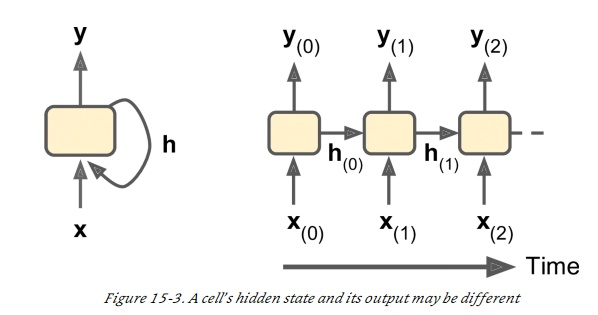

We will see later that additional transformations may be enacted on the information that's eventually transmitted through the hidden channels that is not enacted on the information that leaves as y_t.

### Input and Output Sequences:
Now, since RNNs can accept sequences of vectors as inputs, we can have a sequence of inputs and a sequence of outputs. This allows for four different salient possible input-output based architectures, namely:
    (1) **Sequence-to-sequence architectures**: The network accepts a sequence of inputs, accepting a different input at each frame. Further, at each frame, the network produces a vector output, that sequence of output vectors being the total output. Hence, we call this network a sequence to sequence RNN. This could be used for predicting stock prices for each day, for example.
    (2) **Sequence-to-vector architectures:** We accept a sequence of inputs but output a single vector at the end of the frames. So, we could use this for doing, say, sentiment analysis, whereing we output some values between -1 and 1 to determine how much some content was determined enjoyable by a human audience. So, we could plug in vectors of movie reviews.
    (3) **Vector-to-sequence architectures:** We input only a single vector on the first frame and then take every output generated. We might want to do this to put captions on an image.
    (4) **encoder-decoder architectures:** These are a concatenation of sequence-to-vector & vector-to-sequence architectures, whereing we call the first the *encoder* and the second the *decoder*. So, the output of the encoder is a vector that is fed to the decoder. This is a useful architecture when the input to be processed has a temporal structure such that its constituent parts at the end of the structure determine the shape of the structure at the beginning time. So, less abstractly, this is the case when we want to translate from English to Japanese, or someother language. We first train an encoder to learn how to encode our English sentence into a palatable vector for the decoder, and then the decoder converts that vector into Japanese, and we hope that the output is a well-formed, sensible, Japanese sentence.

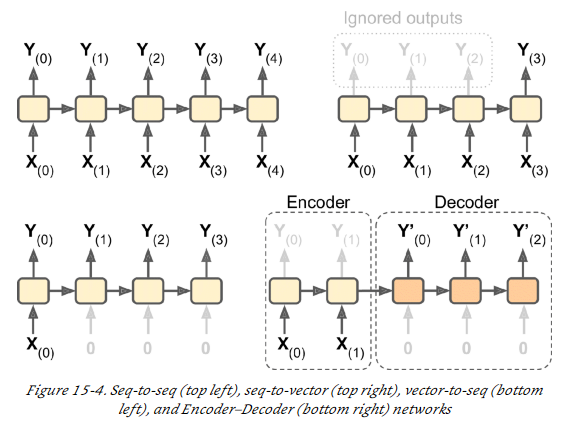

# Training RNNs:
To train an RNN, we simply do backprop but we "roll the net out through time," and so we call it backprop through time (BPTT). So, there is not much difference than regular training of neural networks. The biggest difference is that the error can be propagated backward from more than one output, since we can have sequences of outputs. Usually, however, we only select a few of the outputs to backpropagate the error, and in the case of sequence-to-vector networks, we only backprop a single error, namely that arising from the only output.

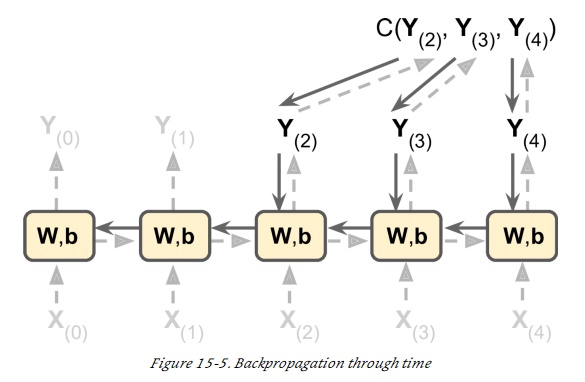

# Forecasting a Time Series:
A time series is a series of data that unfolds over time. So, e.g., this could be data recorded every hour of how many users are on a website, or, say, data from our companie's finances such as debt, sales, employee count, etc., for measuring the health of the company. In the former case, we are only tracking a single value per time step, namely the number of users per hour, and so we say that it's a *univariate* time series. In the latter case, we track multiple values per time step and we therefore call it a *multivariate* time series. The purpose of time series analysis is to either predict future values or to postdict past values, since we may have missing data; the latter is called imputation.

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
    return series.astype(np.float32)

In [151]:
# Creating training, validation, and test sets:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000: 9000, :n_steps], series[7000: 9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [43]:
# Finding a baseline metric for performance by using a naive forecast and taking the MSE
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020553501

So, even with a naive guess of the first two thousand points, we only have an MSE of 2%

In [46]:
# Next, a simple regression model:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)])
model.compile(loss='MSE', metrics='MSE')

In [51]:
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20)

Epoch 1/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0035 - val_MSE: 0.0035
Epoch 2/20
219/219 [==============================] - 0s 761us/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0032 - val_MSE: 0.0032
Epoch 3/20
219/219 [==============================] - 0s 732us/step - loss: 0.0033 - MSE: 0.0033 - val_loss: 0.0032 - val_MSE: 0.0032
Epoch 4/20
219/219 [==============================] - 0s 735us/step - loss: 0.0033 - MSE: 0.0033 - val_loss: 0.0032 - val_MSE: 0.0032
Epoch 5/20
219/219 [==============================] - 0s 736us/step - loss: 0.0033 - MSE: 0.0033 - val_loss: 0.0033 - val_MSE: 0.0033
Epoch 6/20
219/219 [==============================] - 0s 709us/step - loss: 0.0033 - MSE: 0.0033 - val_loss: 0.0031 - val_MSE: 0.0031
Epoch 7/20
219/219 [==============================] - 0s 717us/step - loss: 0.0033 - MSE: 0.0033 - val_loss: 0.0033 - val_MSE: 0.0033
Epoch 8/20
219/219 [==============================] - 0s 737us/s

So, even this simple model outperforms the naive baseline. Now, the RNN:

### Implementing a Simple RNN:
In a simple RNN, the hidden state is the same as the output from the previous time step. Further, as stated, RNNs can take inputs of arbitrary size, and so when we implement this RNN, we will not specify the shape of the first input dimension. Also, by default, the activation function for units of a simple RNN is hyperbolic tangent.

In [142]:
model2 = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])])

In [143]:
model2.compile(loss="mse", metrics='mse')

In [144]:
X_train = np.atleast_3d(X_train)
X_valid = np.atleast_3d(X_valid)

In [145]:
model2.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20)

Epoch 1/20
219/219 [==============================] - 2s 6ms/step - loss: 0.6794 - mse: 0.6794 - val_loss: 0.4573 - val_mse: 0.4573
Epoch 2/20
219/219 [==============================] - 1s 4ms/step - loss: 0.3884 - mse: 0.3884 - val_loss: 0.2932 - val_mse: 0.2932
Epoch 3/20
219/219 [==============================] - 1s 4ms/step - loss: 0.2916 - mse: 0.2916 - val_loss: 0.2460 - val_mse: 0.2460
Epoch 4/20
219/219 [==============================] - 1s 4ms/step - loss: 0.2451 - mse: 0.2451 - val_loss: 0.1988 - val_mse: 0.1988
Epoch 5/20
219/219 [==============================] - 1s 4ms/step - loss: 0.1943 - mse: 0.1943 - val_loss: 0.1512 - val_mse: 0.1512
Epoch 6/20
219/219 [==============================] - 1s 4ms/step - loss: 0.1466 - mse: 0.1466 - val_loss: 0.1416 - val_mse: 0.1416
Epoch 7/20
219/219 [==============================] - 1s 4ms/step - loss: 0.1410 - mse: 0.1410 - val_loss: 0.1381 - val_mse: 0.1381
Epoch 8/20
219/219 [==============================] - 1s 4ms/step - loss: 0.

##### Implementing a Deep RNN:

In [152]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, input_shape=[None, 1], return_sequences=True),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)])

In [153]:
model.compile(loss="mse", metrics="mse")

In [155]:
X_train, X_valid = np.reshape(X_train, (*X_train.shape, 1)), np.reshape(X_valid, (*X_valid.shape, 1))

In [158]:
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 4s 12ms/step - loss: 0.0299 - mse: 0.0299 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 2/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 3/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 4/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 5/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 6/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 7/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 8/20
219/219 [==============================] - 2s 11ms/step - 

In [159]:
model_RNN_with_dense_output = keras.models.Sequential([
    keras.layers.SimpleRNN(20, input_shape=[None, 1], return_sequences=True),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

In [160]:
model_RNN_with_dense_output.compile(loss='mse', metrics='mse')

In [161]:
model_RNN_with_dense_output.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20)

Epoch 1/20
219/219 [==============================] - 3s 9ms/step - loss: 0.0746 - mse: 0.0746 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 7/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 8/20
219/219 [==============================] - 2s 8ms/step - loss: 0.

### Forecasting Several Time Steps Ahead:
We can make our output layer size ten if we want to predict the next ten points in a sequence as opposed to simply predicting the next point. We could also do this less efficiently by predicting one point at a time and then adding that point to the set that we generate our predictions from. But I am not going to do that. So, we just need to make our y sets have size ten instead of 1.

In [5]:
n_steps = 50
series = np.reshape(generate_time_series(10000, n_steps + 10), (10000, 60, 1))
X_train, y_train = series[:7000, :n_steps], series[:7000, -10:, 0]

In [9]:
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [11]:
model = keras.models.Sequential([keras.layers.SimpleRNN(20, input_shape=[None, 1], return_sequences=True),
                                keras.layers.SimpleRNN(20),
                                keras.layers.Dense(10)])

In [12]:
model.compile(loss='mse', metrics='mse')

In [13]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20)

Epoch 1/20
219/219 [==============================] - 3s 9ms/step - loss: 0.0958 - mse: 0.0958 - val_loss: 0.0322 - val_mse: 0.0322
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0258 - mse: 0.0258 - val_loss: 0.0198 - val_mse: 0.0198
Epoch 3/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0199 - mse: 0.0199 - val_loss: 0.0168 - val_mse: 0.0168
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0180 - mse: 0.0180 - val_loss: 0.0159 - val_mse: 0.0159
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0167 - mse: 0.0167 - val_loss: 0.0170 - val_mse: 0.0170
Epoch 6/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0161 - mse: 0.0161 - val_loss: 0.0166 - val_mse: 0.0166
Epoch 7/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0153 - mse: 0.0153 - val_loss: 0.0132 - val_mse: 0.0132
Epoch 8/20
219/219 [==============================] - 2s 7ms/step - loss: 0.

In [20]:
test_preds = model.predict(X_test)

In [22]:
np.mean(keras.metrics.mean_squared_error(y_test, test_preds))

0.015142473

We can make the model much better by training each step to predict the next ten points. We do this by modifying the y sets.

In [24]:
Y = np.empty((10000, n_steps, 10)) # ten thousand size-50 sets of 10D vectors
for step_ahead in range( 1, 10 + 1):
    Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [28]:
model = keras.models.Sequential([keras.layers.SimpleRNN(20, input_shape=[None, 1], return_sequences=True),
                                keras.layers.SimpleRNN(20, return_sequences=True),
                                # We need return_sequences  ^^^  on since each layer is judged on a 10D vector
                                keras.layers.Dense(10)])

In [29]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:,-1], Y_pred[:,-1])
optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(loss='mse', metrics=last_time_step_mse, optimizer=optimizer)

Outputting sequences is actually useful for generating art or music. The RNN picks up on patterns in the art and then generates what it thinks the art would look or sound like if it were continued.

In [30]:
model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=20)

Epoch 1/20
219/219 [==============================] - 3s 9ms/step - loss: 0.0631 - last_time_step_mse: 0.0532 - val_loss: 0.0390 - val_last_time_step_mse: 0.0269
Epoch 2/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0361 - last_time_step_mse: 0.0237 - val_loss: 0.0310 - val_last_time_step_mse: 0.0182
Epoch 3/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0294 - last_time_step_mse: 0.0173 - val_loss: 0.0282 - val_last_time_step_mse: 0.0174
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0271 - last_time_step_mse: 0.0157 - val_loss: 0.0261 - val_last_time_step_mse: 0.0144
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0252 - last_time_step_mse: 0.0136 - val_loss: 0.0229 - val_last_time_step_mse: 0.0107
Epoch 6/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0238 - last_time_step_mse: 0.0116 - val_loss: 0.0210 - val_last_time_step_mse: 0.0085
Epoch 7/20
219/219 [========

## Handling Long Sequences:
### Unstable Gradients:
One of the problems of long sequences is that our gradients can become unstable, i.e., either vanish or explode. This is because, as the RNN is unrolled over time, the hidden cells are using the same weights at each time step, and so if gradient descent updates the weight in such a way that the weight is slightly larger than before, that difference is amplified in each frame if the activation function is non-saturating, such as Relu (i.e., the function is not asymptotic like tanh, a saturating function). For this reason, the default activation function for nodes of RNN layers is tanh.

## Long-Term Memory:
With the simple RNN cells that we have used so far, input data from early time steps is entirely forgot by later time steps. This is not good for tasks wherein the end of a sequence has crucial dependencies on the structure of the beginning of the sequence. Thus, to amend this problem, cell architectures have been invented that are capable of having long-term memory. Most famously, we have the LSTM cell from Schmidhuber et al.

In [3]:
# Implementing LSTM cells is very easy
model = keras.models.Sequential([
    keras.layers.LSTM(20, input_shape=[None, 1], return_sequences=True),
    keras.layers.LSTM(20),
    keras.layers.Dense(10)
])

An LSTM cell works by using 4 conjoining four fully connected (FC) layers, each performing a different function, and then having those four layers operate on the previous hidden state h_t-1 (the short-term memory), a long-term memory tensor c_t-1 that is passed through each LSTM layer, and the input x_t. So, each FC layer receives x_t and h_t-1 as input. Then, in order, these layers are the f (forget), g (get), i (input), and o (output) layer. So, the f gate does f(h_t-1, x_t) and then the activation function attached to f is the logistic function, so the output is between 0 and 1. Then, this output does tensor element-by-element multiplication on c_t-1, which is a way of erasing and holding onto entries of c_t-1 that are not needed and needed, respectively; hence, we call f the forget gate, since it choose what parts of c_t-1 should be erased. Next, we have the g gate, which is simply a regular layer of a simple RNN. So, g(x_t, h_t-1) has a tanh activation function. Then, the output from g performs tensor addition with the output from i, i.e., g(x_t, h_t-1) (+) i(x_t, h_t-1) which then does element-by-element multiplication with c_t-1 after c_t-1 encountered the f gate's output. Next, c_t-1 is shuffled off into two directions: first as c_t for the next LSTM cell and secondly through a tanh activation function to be element-by-element multiplied by the output from the o gate, namely tanh(c_t-1) (x) o(x_t, h_t-1). Then, this second direction for c_t-1 becomes h_t for the next LSTM cell. Also, this is used as the output y_t for the current LSTM cell.

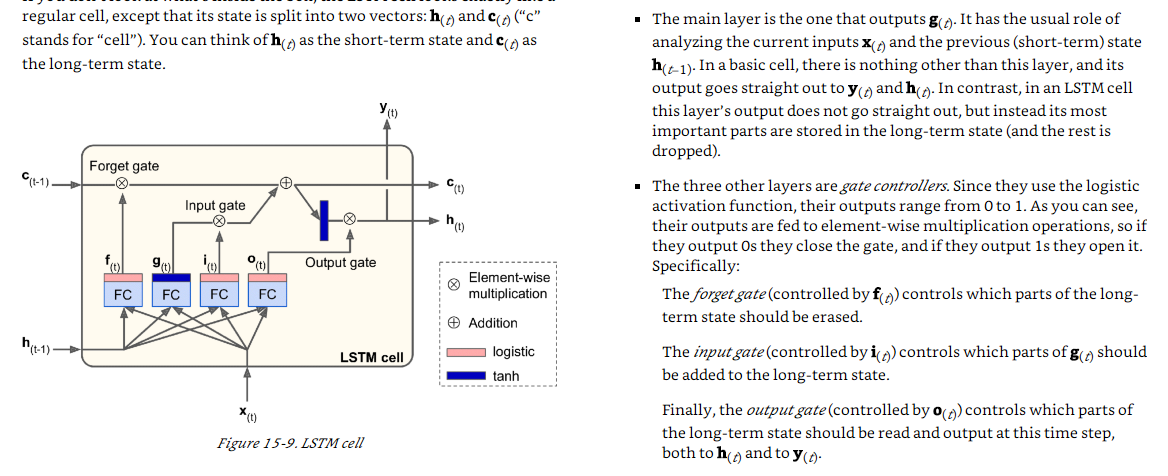

So, the general motivation behind the idea of an LSTM cell seems obvious. Namely, we have problems involving sequences wherein the terminal structure of the sequence has dependencies on initial structure of the sequence. So, we cannot learn such a sequence if we can only focus on short-term structure. Thus, we want a neural network architecture that is capable of learning how to focus on long-term connections. Therefore, we just pass a tensor c_t through the network that is a function of layers trained to erase old information and add current information. Then, to affect the output, we have this c_t tensor operate on the input before yielding the output. Hence, we now have long-term dependencies in the neural network.

#### The Gated Recurrent Unit (GRU)
The GRU is a simplified version of the LSTM. That is, it is supposed to be an implementation of the same idea of the LSTM but with less computational complexity. So, the GRU has no c_t vector and one less gate (no forget gate) but rather merges the functions of its gates and packs the long-term and short-term memory into the hidden vector. This is done with two logistic activation function fully connected layers which both receive x_t and h_t-1. The first layer r learns an element-by-element multiplication operation that's applied to h_t-1 before being passed to the single tanh layer. The next logistic activation function layer is z, which learns a multiplication operation to be applied to the h_t-1 vector before being output and also sends its signal through a separate channel that takes 1-x on all its outputs (so, if z(x_i_j) = 1, that output is transformed to zero) and then multiplies that against the output of the tanh layer before the output of the tanh layer is added to the h_t-1 vector that has already received all transforms. Then, h_t-1 is output as y_t and h_t.